In [2]:
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm


In [3]:
from transformers import AutoTokenizer, BertForMaskedLM
#from transformers import BertTokenizer, BertModel

#tokenizer = BertTokenizer.from_pretrained('google/multiberts-seed_0-step_40k')
#model = BertForMaskedLM.from_pretrained("google/multiberts-seed_0-step_40k")

In [4]:
from transformers import AutoTokenizer, BertForMaskedLM
tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_1-step_40k')
model = BertForMaskedLM.from_pretrained("google/multiberts-seed_1-step_40k")


Some weights of the model checkpoint at google/multiberts-seed_1-step_40k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# df = pd.read_csv('data_processed/test.csv')
# df = pd.concat([df, pd.DataFrame({'prompt': ['My dad loves riding his bike, and my mom loves driving her car. My [MASK] drove me to school.'], 'label': ['mom'], 'distractor': ['dad']})], ignore_index=True)
# df = pd.concat([df, pd.DataFrame({'prompt': ['The city is located far from me while the park is close. It took me a long time to get to the [MASK].'], 'label': ['city'], 'distractor': ['park']})], ignore_index=True)
# df = pd.concat([df, pd.DataFrame({'prompt': ['I really like pizza and I hate beet. I usually eat [MASK].'], 'label': ['pizza'], 'distractor': ['beet']})], ignore_index=True)
# df = pd.concat([df, pd.DataFrame({'prompt': ['My friend is really nice to me, while my teacher is really mean. My [MASK] screamed at me.'], 'label': ['friend'], 'distractor': ['teacher']})], ignore_index=True)

In [6]:
df = pd.read_csv('data_processed/niki.csv')

In [7]:
seed = 1

In [8]:
list_of_checkpoints = [f'google/multiberts-seed_{seed}-step_{i}k' for i in range(0, 200, 20)] + [f'google/multiberts-seed_{seed}-step_{i}k' for i in range(200, 2001, 100)]

In [17]:
df

,prompt,label1,label2,distractor1,distractor2,length,plural_match,predicted_token0k,top_proba0k,correct0k,...,correct1700k,predicted_token1800k,top_proba1800k,correct1800k,predicted_token1900k,top_proba1900k,correct1900k,predicted_token2000k,top_proba2000k,correct2000k
0,The tourist hired the guides that the locals a...,guides,guides,tourist,tourist,short,mismatch,guides,vulture,True,...,False,tourist,tourists,False,tourist,tourists,False,tourist,tourists,False
1,The tourists hired the guides that the locals ...,guides,guides,tourists,tourists,short,match,tourists,vulture,False,...,False,tourists,tourists,False,tourists,tourists,False,tourists,tourists,False
2,The tourist hired the guides that two days ago...,guides,guides,tourist,tourist,long,mismatch,tourist,caring,False,...,False,tourist,tourists,False,tourist,tourists,False,tourist,tourists,False
3,The tourists hired the guides who two days ago...,guides,guides,tourists,tourists,long,match,tourists,caring,False,...,False,tourists,tourists,False,tourists,tourists,False,tourists,tourists,False
4,The coach removed the gymnasts that the fans d...,gymnasts,gymnasts,coach,coach,short,mismatch,coach,maui,False,...,False,coach,coaches,False,coach,fans,False,coach,coaches,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,The editors censored the journalists that last...,journalists,journalists,editors,editors,long,match,journalists,caring,True,...,False,editors,readers,False,editors,readers,False,editors,readers,False
124,The donor bored the researchers that interns d...,researchers,researchers,donor,donor,short,mismatch,donor,bram,False,...,True,researchers,researchers,True,researchers,researchers,True,researchers,researchers,True
125,The donors bored the researchers that interns ...,researchers,researchers,donors,donors,short,match,researchers,bram,True,...,True,researchers,researchers,True,researchers,researchers,True,researchers,researchers,True
126,The donor bored the researchers that last year...,researchers,researchers,donor,donor,long,mismatch,researchers,kelly,True,...,True,researchers,grant,True,researchers,process,True,researchers,grant,True


In [9]:
# Function to predict the masked token in a given text
def predict_masked_token(row):
    with torch.no_grad():
        text, input_label1,input_label2, input_distractor1,input_distractor2 = row['prompt'], row['label1'], row['label2'],row['distractor1'],row['distractor2']

        # Encode the text
        encoded_input = tokenizer(text, return_tensors='pt')
        mask_token_index = torch.where(encoded_input['input_ids'] == tokenizer.mask_token_id)[1].item()
        #mask_token_index = (encoded_input.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

        # Get the label and distractor indices
        values = [input_label1,input_label2,input_distractor1,input_distractor2]
        label_index1 = tokenizer.encode(input_label1, add_special_tokens=False)[0]
        label_index2 = tokenizer.encode(input_label2, add_special_tokens=False)[0]
        distractor_index1 = tokenizer.encode(input_distractor1,   add_special_tokens=False)[0]
        distractor_index2 = tokenizer.encode(input_distractor2,   add_special_tokens=False)[0]
        # Predict the masked token
        output = model(**encoded_input)
        predictions = output.logits
        masked_token_predictions = predictions[0, mask_token_index]
        masked_token_predictions_softmax = torch.softmax(masked_token_predictions, dim=0)
        masked_token_predictions_softmax_label_distractor = masked_token_predictions_softmax[[label_index1,label_index2,distractor_index1,distractor_index2]]

        top_predicted_token = masked_token_predictions_softmax.argmax(axis=-1).item()
        decode_top_predicted_token = tokenizer.decode(top_predicted_token)
        # Get the predicted token index
        predicted_token_index = torch.argmax(masked_token_predictions_softmax_label_distractor).item()
        predicted_token = values[predicted_token_index]
        return predicted_token,decode_top_predicted_token

#df['predicted_token'] = df.apply(lambda row: predict_masked_token(row), axis=1)

In [10]:
df

,prompt,label1,label2,distractor1,distractor2,length,plural_match
0,The tourist hired the guides that the locals a...,guides,guides,tourist,tourist,short,mismatch
1,The tourists hired the guides that the locals ...,guides,guides,tourists,tourists,short,match
2,The tourist hired the guides that two days ago...,guides,guides,tourist,tourist,long,mismatch
3,The tourists hired the guides who two days ago...,guides,guides,tourists,tourists,long,match
4,The coach removed the gymnasts that the fans d...,gymnasts,gymnasts,coach,coach,short,mismatch
...,...,...,...,...,...,...,...
123,The editors censored the journalists that last...,journalists,journalists,editors,editors,long,match
124,The donor bored the researchers that interns d...,researchers,researchers,donor,donor,short,mismatch
125,The donors bored the researchers that interns ...,researchers,researchers,donors,donors,short,match
126,The donor bored the researchers that last year...,researchers,researchers,donor,donor,long,mismatch


In [11]:
# tokenizer = AutoTokenizer.from_pretrained("google/multiberts-seed_0-step_2000k")
# model = BertForMaskedLM.from_pretrained("google/multiberts-seed_0-step_2000k")

In [12]:
from transformers import AutoTokenizer, BertForMaskedLM
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

accuracies = []

# for each checkpoint, load the model and predict the masked token
for checkpoint in tqdm(list_of_checkpoints):
    # load the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = BertForMaskedLM.from_pretrained(checkpoint)

    step = checkpoint.split('_')[-1]

    # predict the masked token
    pred_col = f'predicted_token{step}'
    top_proba_col = f'top_proba{step}'
    correct_col = f'correct{step}'

    # predict the masked token
    #print(df.apply(lambda row: predict_masked_token(row), axis=1))
    df[[pred_col,top_proba_col]] = df.apply(lambda row: predict_masked_token(row), axis=1,result_type="expand")
    df[correct_col] = (df[pred_col] == df['label1']) | (df[pred_col] == df['label2'])

    # calculate the accuracy
    accuracy = np.array(df[correct_col]).mean()
    #df.groupby(['plural_match', 'length'])[correct_col].mean().to_csv(f'accuracy/{checkpoint}.csv')
    print(checkpoint, accuracy)
    # save the accuracy
    accuracies.append(accuracy)


Some weights of the model checkpoint at google/multiberts-seed_1-step_0k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_0k 0.609375


Some weights of the model checkpoint at google/multiberts-seed_1-step_20k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_20k 0.6796875


Some weights of the model checkpoint at google/multiberts-seed_1-step_40k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_40k 0.7265625


Some weights of the model checkpoint at google/multiberts-seed_1-step_60k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_60k 0.5234375


Some weights of the model checkpoint at google/multiberts-seed_1-step_80k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_80k 0.6484375


Some weights of the model checkpoint at google/multiberts-seed_1-step_100k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_100k 0.5625


Some weights of the model checkpoint at google/multiberts-seed_1-step_120k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_120k 0.5703125


Some weights of the model checkpoint at google/multiberts-seed_1-step_140k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_140k 0.5859375


Some weights of the model checkpoint at google/multiberts-seed_1-step_160k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_160k 0.5625


Some weights of the model checkpoint at google/multiberts-seed_1-step_180k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_180k 0.5859375


Some weights of the model checkpoint at google/multiberts-seed_1-step_200k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_200k 0.578125


Some weights of the model checkpoint at google/multiberts-seed_1-step_300k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_300k 0.6171875


Some weights of the model checkpoint at google/multiberts-seed_1-step_400k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_400k 0.578125


Some weights of the model checkpoint at google/multiberts-seed_1-step_500k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_500k 0.5390625


Some weights of the model checkpoint at google/multiberts-seed_1-step_600k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_600k 0.59375


Some weights of the model checkpoint at google/multiberts-seed_1-step_700k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_700k 0.625


Some weights of the model checkpoint at google/multiberts-seed_1-step_800k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_800k 0.671875


Some weights of the model checkpoint at google/multiberts-seed_1-step_900k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_900k 0.5625


Some weights of the model checkpoint at google/multiberts-seed_1-step_1000k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1000k 0.6796875


Some weights of the model checkpoint at google/multiberts-seed_1-step_1100k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1100k 0.5546875


Some weights of the model checkpoint at google/multiberts-seed_1-step_1200k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1200k 0.6015625


Some weights of the model checkpoint at google/multiberts-seed_1-step_1300k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1300k 0.53125


Some weights of the model checkpoint at google/multiberts-seed_1-step_1400k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1400k 0.578125


Some weights of the model checkpoint at google/multiberts-seed_1-step_1500k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1500k 0.484375


Some weights of the model checkpoint at google/multiberts-seed_1-step_1600k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1600k 0.578125


Some weights of the model checkpoint at google/multiberts-seed_1-step_1700k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1700k 0.5703125


Some weights of the model checkpoint at google/multiberts-seed_1-step_1800k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1800k 0.5703125


Some weights of the model checkpoint at google/multiberts-seed_1-step_1900k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_1900k 0.5625


Some weights of the model checkpoint at google/multiberts-seed_1-step_2000k were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


google/multiberts-seed_1-step_2000k 0.578125



In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_by_columns(df, col1,col2):
    correct_cols = [col for col in df.columns if 'correct' in col]
    df_groupby = df.groupby([col1,col2])[correct_cols].mean()
    # plot the accuracy by checkpoint for each dependency type and each match type using the df_groupby
    sns.set_theme(style="whitegrid")
    steps = np.arange(len(list_of_checkpoints))
    sns.lineplot(x=steps, y=df_groupby.iloc[0], label = df_groupby.index[0])
    sns.lineplot(x=steps, y=df_groupby.iloc[1], label = df_groupby.index[1])
    sns.lineplot(x=steps, y=df_groupby.iloc[2], label = df_groupby.index[2])
    sns.lineplot(x=steps, y=df_groupby.iloc[3], label = df_groupby.index[3])
    #define axis
    plt.xlabel('Checkpoints')
    plt.ylabel('Accuracy')
    plt.show()

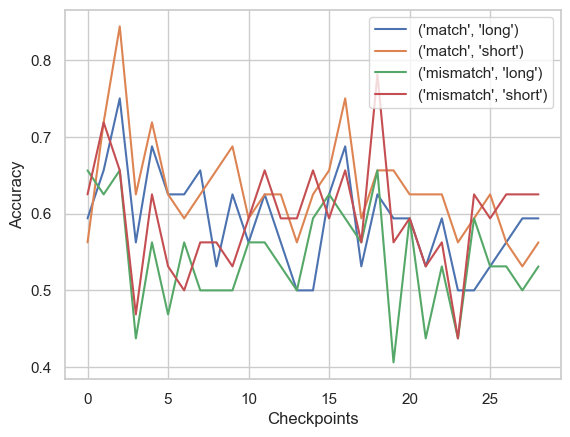

In [14]:
## Run only on Niki
plot_by_columns(df,'plural_match','length')

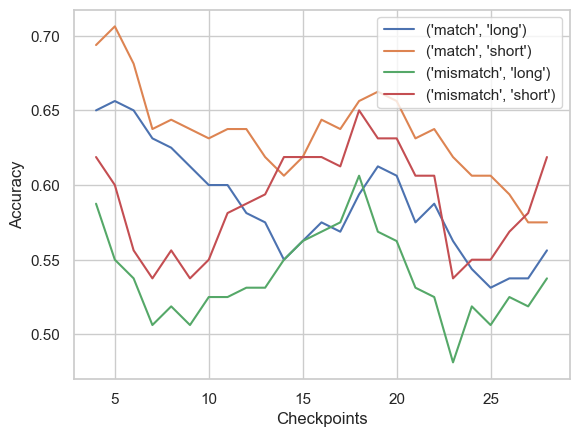

In [15]:
# plot using matplotlib rolling average
import matplotlib.pyplot as plt
import numpy as np
correct_cols = [col for col in df.columns if 'correct' in col]
df_groupby = df.groupby(['plural_match','length'])[correct_cols].mean()
# plot the accuracy by checkpoint for each dependency type and each match type using the df_groupby
steps = np.arange(len(list_of_checkpoints))
plt.plot(steps, df_groupby.iloc[0].rolling(window=5).mean(), label = df_groupby.index[0])
plt.plot(steps, df_groupby.iloc[1].rolling(window=5).mean(), label = df_groupby.index[1])
plt.plot(steps, df_groupby.iloc[2].rolling(window=5).mean(), label = df_groupby.index[2])
plt.plot(steps, df_groupby.iloc[3].rolling(window=5).mean(), label = df_groupby.index[3])
# define axis
plt.xlabel('Checkpoints')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# Run only on Naama
plot_by_columns(df,'dependency','match')

KeyError: 'dependency'

In [ ]:
df.groupby(['dependency', 'match'])["correct"].mean().plot(kind='bar')

In [ ]:
# Calculate accuracy
import numpy as np
accuracy = np.array(df['predicted_token'] == df['label']).mean()

# Print accuracy
print("Accuracy:", accuracy)

In [ ]:
df['correct'] = df['predicted_token'] == df['label']

In [ ]:
df.groupby(['plural_match', 'length'])["correct"].mean()

In [ ]:
# plot the accuracy by length
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="length", y="correct", hue="plural_match", data=df)
plt.show()

In [ ]:
# plot the accuracy by length
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="length", y="correct", hue="plural_match", data=df)
plt.show()

In [ ]:
# # from transformers import AutoTokenizer, BertForMaskedLM
# # tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0-step_40k')
# # model = BertForMaskedLM.from_pretrained("google/multiberts-seed_0-step_40k")
# from transformers import AutoTokenizer, BertForMaskedLM
# import torch
#
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = BertForMaskedLM.from_pretrained("bert-base-uncased")
#
# text="The tourist hired the guides that the locals angered due to a misunderstanding. Therefore, the locals angered the [MASK]"
# input_label = "guides"
# input_distractor = "tourist"
#
# with torch.no_grad():
#     # Encode the text
#     encoded_input = tokenizer(text, return_tensors='pt')
#     mask_token_index = torch.where(encoded_input['input_ids'] == tokenizer.mask_token_id)[1].item()
#     # mask_token_index = (encoded_input.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
#
#     # Get the label and distractor indices
#     values = [input_label,input_distractor]
#     label_index = tokenizer.encode(input_label, add_special_tokens=False)[0]
#     distractor_index = tokenizer.encode(input_distractor,   add_special_tokens=False)[0]
#     # Predict the masked token
#     output = model(**encoded_input)
#     predictions = output.logits
#     masked_token_predictions = predictions[0, mask_token_index]
#     masked_token_predictions_softmax = torch.softmax(masked_token_predictions, dim=0)
#     masked_token_predictions_softmax_label_distractor = masked_token_predictions_softmax[[label_index,distractor_index]]
#
#     # Get the predicted token index
#     predicted_token_index = torch.argmax(masked_token_predictions_softmax_label_distractor).item()
#     predicted_token = values[predicted_token_index]


In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = BertForMaskedLM.from_pretrained("bert-base-uncased")

tokenizer = AutoTokenizer.from_pretrained("google/multiberts-seed_0")
model = BertForMaskedLM.from_pretrained("google/multiberts-seed_0")

# predict the masked token
step = 'pretrained'
pred_col = f'predicted_token{step}'
correct_col = f'correct{step}'

# predict the masked token
df[pred_col] = df.apply(lambda row: predict_masked_token(row), axis=1)
df[correct_col] = df[pred_col] == df['label']

# calculate the accuracy
accuracy = np.array(df[correct_col]).mean()
#df.groupby(['plural_match', 'length'])[correct_col].mean().to_csv(f'accuracy/{checkpoint}.csv')
print('example', accuracy)
# save the accuracy
#accuracies.append(accuracy)

In [ ]:
from transformers import AutoTokenizer, BertForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

inputs = tokenizer("The capital of France is [MASK].", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# retrieve index of [MASK]
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]

predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
tokenizer.decode(predicted_token_id)

labels = tokenizer("The capital of France is Paris.", return_tensors="pt")["input_ids"]
# mask labels of non-[MASK] tokens
labels = torch.where(inputs.input_ids == tokenizer.mask_token_id, labels, -100)

outputs = model(**inputs, labels=labels)
round(outputs.loss.item(), 2)